In [1]:
import os
import cv2
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
from PIL import Image
from tqdm.notebook import tqdm
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms as T
from torchvision.datasets import MNIST
from torchsummary import summary
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from datasets import load_metric
from transformers import SegformerImageProcessor, BertModel, BertConfig
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH_DATASETS = '/home/morten/Documents/Algorithms-for-Automated-Driving/code/solutions/lane_detection/data_lane_segmentation/'

In [2]:
class_names = ['background', 'left', 'right']

class_rgb_values = [[0,0,0], [1,1,1], [2,2,2]]

print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Class Names:  ['background', 'left', 'right']
Class RGB values:  [[0, 0, 0], [1, 1, 1], [2, 2, 2]]


In [3]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'left', 'right']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'left', 'right']
Class RGB values:  [[0, 0, 0], [1, 1, 1], [2, 2, 2]]


In [4]:
# Visualize from dataloader or prediction
def visualize_tensor(tensor_input, gray = False):
    if gray == False:
        img = tensor_input[0,:,:,:]
        img = img.detach().cpu().numpy()

        img = np.transpose(img, (1,2,0))
        img = img/np.amax(img)
        img = np.clip(img, 0, 1)
        
        plt.imshow(img)
        plt.show()
    elif gray == True:
        img = tensor_input[0,0,:,:]
        img = img.detach().cpu().numpy()

        plt.imshow(img, cmap='gray')
        plt.show()



# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [5]:
class LaneSegmentDataset(Dataset):
    def __init__(self, img_dir, label_dir, list_of_filenames, class_rgb_values=None):
        super().__init__()
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.list_of_filenames = list_of_filenames
        self.class_rgb_values = class_rgb_values


    def __len__(self):
        return len(self.list_of_filenames)

    def __getitem__(self, idx):
        img = cv2.cvtColor(cv2.imread(self.img_dir + self.list_of_filenames[idx] + '.png'), cv2.COLOR_BGR2RGB)
        label = cv2.cvtColor(cv2.imread(self.label_dir + self.list_of_filenames[idx] + '_label.png', cv2.IMREAD_GRAYSCALE), cv2.COLOR_GRAY2RGB)

        # one-hot-encode the mask
        label = one_hot_encode(label, self.class_rgb_values).astype(float)

        img = torch.from_numpy(img).float()
        label = torch.from_numpy(label).float()

        img = torch.permute(img, (2,0,1))
        label = torch.permute(label, (2,0,1))


        return img, label

In [6]:
img_dir = PATH_DATASETS + 'train/'
label_dir = PATH_DATASETS + 'train_label/'

name_fit = []
for dirname, _, filenames_fit in os.walk(img_dir):
    for filename_fit in filenames_fit:
        name_fit.append(filename_fit.split('.')[0])
img_fit = pd.DataFrame({'id': name_fit}, index = np.arange(0, len(name_fit)))
lane_train_path, lane_val_path = train_test_split(img_fit['id'].values, test_size=0.2, train_size=0.8, random_state=10)

lane_train_dataset = LaneSegmentDataset(img_dir, label_dir, lane_train_path, class_rgb_values)
lane_val_dataset = LaneSegmentDataset(img_dir, label_dir, lane_val_path, class_rgb_values)


test_img_dir = PATH_DATASETS + 'val/'
test_label_dir = PATH_DATASETS + 'val_label/'

name_test = []
for dirname, _, filenames_test in os.walk(test_img_dir):
    for filename_test in filenames_test:
        name_test.append(filename_test.split('.')[0])
img_test = pd.DataFrame({'id': name_test}, index =np.arange(0, len(name_test)))
lane_temp, lane_test = train_test_split(img_test['id'].values, test_size=128, train_size=1, random_state=10)

lane_test_dataset = LaneSegmentDataset(test_img_dir, test_label_dir, lane_test, class_rgb_values)

batch_size = 4
num_workers = 8

train_dataloader = DataLoader(lane_train_dataset, batch_size=batch_size, num_workers=num_workers)
val_dataloader = DataLoader(lane_val_dataset, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(lane_test_dataset, batch_size=batch_size, num_workers=num_workers)


torch.Size([4, 3, 512, 1024]) torch.Size([4, 3, 512, 1024])
(3, 512, 1024)


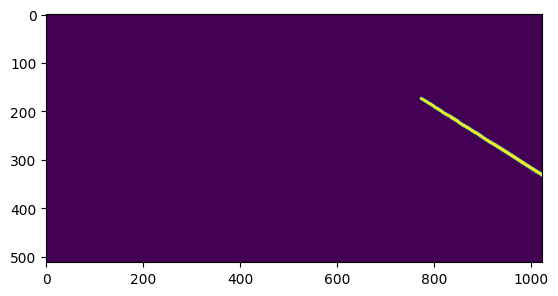

In [7]:
for step, (x,y) in enumerate(train_dataloader):
    if step < 1:
        print(x.shape, y.shape)
        img = x[0,:,:,:]
        img = img.detach().cpu().numpy().astype(int)
        img = np.transpose(img, (1,2,0))
        label = y[0,:,:,:]
        label = label.detach().cpu().numpy().astype(int)
        print(label.shape)
        # np.transpose(label, (1,2,0))
        plt.imshow(label[2])
    else:
        break

In [8]:
class LaneSegmentDataModule(pl.LightningDataModule):

    def __init__(self, dataset, dataset_val=None, batch_size: int=2):
        super().__init__()
        self.batch_size = batch_size
        self.dataset = dataset
        self.dataset_val = dataset_val

    def prepare_data(self):
        pass

    def setup(self, stage: str):
        if stage == 'fit':
            self.dataset = self.dataset
            self.dataset_val = self.dataset_val

        if stage == 'test':
            self.dataset = self.dataset

    def train_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size)
    
    def val_dataloader(self):
        return DataLoader(self.dataset_val, batch_size=self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size)

In [9]:
data = LaneSegmentDataModule(PATH_DATASETS)
data.prepare_data()
data.setup('fit')

In [10]:
class LitModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.unet = smp.Unet(encoder_name='resnet18', classes=3, encoder_weights=None, in_channels=3, decoder_channels=(256, 128, 64, 32, 3))

    def forward(self, x):
        embedding = self.unet(x)
        return embedding

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self(x)
        # y=y.long()
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self(x)
        # y=y.long()
        loss = F.cross_entropy(logits, y)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def predict_step(self, batch):
        return self(batch)

torch.cuda.empty_cache()

In [11]:
torch.cuda.empty_cache()
model = LitModel()

logger = TensorBoardLogger('tb_logs_lane', name='IPTmodel')

trainer = pl.Trainer(accelerator='gpu',max_epochs=10, logger=logger)
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | unet | Unet | 14.3 M
------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.289    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/morten/mambaforge-pypy3/envs/AI/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=tb_logs_lane/

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
TensorFlow installation not found - running with reduced feature set.
/home/morten/mambaforge-pypy3/envs/AI/lib/python3.8/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.33' not found (required by /home/morten/mambaforge-pypy3/envs/AI/lib/python3.8/site-packages/tensorboard_data_server/bin/server)
/home/morten/mambaforge-pypy3/envs/AI/lib/python3.8/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.34' not found (required by /home/morten/mambaforge-pypy3/envs/AI/lib/python3.8/site-packages/tensorboard_data_server/bin/server)
/home/morten/mambaforge-pypy3/envs/AI/lib/python3.8/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.32' not found (required by /home/morten/mambaforge-pypy3/envs/AI/lib/python3.8/site-packages/tensorboard_data_server/bin/server)
Address alread

torch.Size([4, 3, 512, 1024]) torch.Size([4, 3, 512, 1024])
(3, 512, 1024)


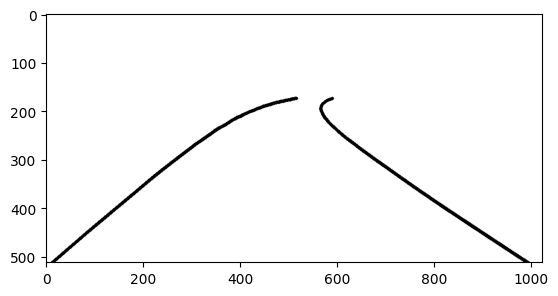

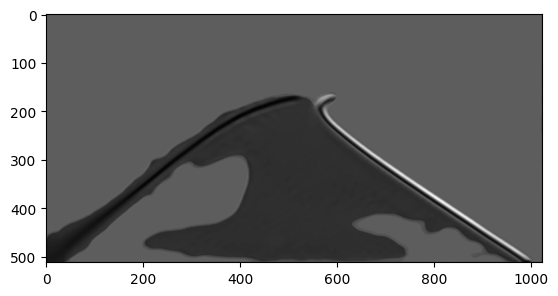

In [13]:
model_from_checkpoint = LitModel.load_from_checkpoint('tb_logs_lane/IPTmodel/version_14/checkpoints/epoch=9-step=6150.ckpt')
model_from_checkpoint.eval()
for i, batch in enumerate(test_dataloader):
    if i<1:
        x, y = batch
        
        print(x.shape, y.shape)
        img = x[0,:,:,:]
        img = img.detach().cpu().numpy().astype(int)
        img = np.transpose(img, (1,2,0))
        label = y[0,:,:,:]
        label = label.detach().cpu().numpy().astype(int)
        print(label.shape)
        # np.transpose(label, (1,2,0))
        plt.imshow(label[0,:,:], cmap='gray')
        plt.show()

        logit = model_from_checkpoint(x)

        visualize_tensor(logit, True)


    else:
        break
